# Classification Problem: Is Candidate from a National Party?

The problem of choice is based on non NOTA candidates from the given election data. We will be training several machine learning models to use as classifiers for our task. In the end I have compiled the insights generated by this.

In [1]:
# Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing

We load the dataset and preprocess the data to clean it up in order to improve our model performance.

In [2]:
df = pd.read_csv("/kaggle/input/general-elections-data-1962-2019/All_States_GE.csv")
df = df[(df.Candidate != 'None of the Above') & (df.Candidate != 'NOTA')] # non NOTA candidate only
df

,State_Name,Assembly_No,Constituency_No,Year,month,Poll_No,DelimID,Position,Candidate,Sex,...,No_Terms,Turncoat,Incumbent,Recontest,MyNeta_education,TCPD_Prof_Main,TCPD_Prof_Main_Desc,TCPD_Prof_Second,TCPD_Prof_Second_Desc,Election_Type
0,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,1,KULDEEP RAI SHARMA,M,...,1.0,False,False,True,Graduate Professional,Business,NaN,Social Work,NaN,Lok Sabha Election (GE)
1,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,2,VISHAL JOLLY,M,...,0.0,False,False,False,Graduate Professional,Liberal Profession or Professional,Lawyer,NaN,NaN,Lok Sabha Election (GE)
2,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,3,PARITOSH KUMAR HALDAR,M,...,0.0,False,False,False,Post Graduate,Agriculture,NaN,NaN,NaN,Lok Sabha Election (GE)
3,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,4,SANJAY MESHACK,M,...,0.0,False,False,True,12th Pass,Business,NaN,Politics,Municipality Member,Lok Sabha Election (GE)
4,Andaman_&_Nicobar_Islands,17,1,2019,4.0,0,4,5,PRAKASH MINJ,M,...,0.0,False,False,False,Post Graduate,Social Work,NaN,NaN,NaN,Lok Sabha Election (GE)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91664,Mysore,3,23,1965,NaN,1,1,3,S.P.N.S.GAWDA,NaN,...,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,Lok Sabha Election (GE)
91665,Uttar_Pradesh,3,76,1965,NaN,1,1,1,N.DEO,M,...,1.0,False,False,False,NaN,NaN,NaN,NaN,NaN,Lok Sabha Election (GE)
91666,Uttar_Pradesh,3,76,1965,NaN,1,1,2,R.S.NIM,NaN,...,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,Lok Sabha Election (GE)
91667,Uttar_Pradesh,3,76,1965,NaN,1,1,3,R.SINGH,NaN,...,0.0,False,False,False,NaN,NaN,NaN,NaN,NaN,Lok Sabha Election (GE)


I've chosen to fill null values for 'Sex' and 'Education' as 'Undeclared' and we will be treating that as a seperate class. The 'Party' column will be our target for this classification: set as 1 if its a national party and 0 else.

In [3]:
# removing inconsistencies for categorical data
df.replace({True: 1, False: 0}, inplace=True)
df.replace(['male', 'MALE'], 'M', inplace=True)
df.replace(['female', 'FEMALE'], 'F', inplace=True)
df.Sex.fillna('Undeclared', inplace=True)
df.MyNeta_education.fillna('Undeclared', inplace=True)
df.Party = [1 if p == 'National Party' else 0 for p in df.Party_Type_TCPD]

Now the features are selected from the dataset. These will hopefully be good indicators for the target.

In [4]:
columns = ['State_Name', 'Year',
        'Position', 'Sex', 'Party',
        'Constituency_Type', 'Turnout_Percentage',
       'Vote_Share_Percentage', 'Margin_Percentage',
       'Contested', 'No_Terms', 'Turncoat', 'Incumbent',
       'Recontest', 'MyNeta_education']
df = df[columns]

df.dropna(inplace=True) # drop the one row without much data

Encoders are used for categorical data and scalers are used for numerical data. These are applied in a ColumnTransformer object. LabelEncoder is used for 'Year' since its an ordinal field.

In [5]:
numerical_columns = ['Turnout_Percentage', 'Vote_Share_Percentage', 'Margin_Percentage', 'Position', 'Contested', 'No_Terms']
label_columns = ['Year']
onehot_columns = ['State_Name', 'Sex', 'Constituency_Type', 'MyNeta_education']

sc = StandardScaler()
oh = OneHotEncoder(handle_unknown='ignore')
lbl = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', sc, numerical_columns),
        ('onehot', oh, onehot_columns),
        ('label', lbl, label_columns)
    ]
)

## Data splitting

Dataset and target vector is split using `train_test_split`. The resulting sets are stored.

In [6]:
X = preprocessor.fit_transform(df.drop('Party', axis=1))
y = df.Party
X = pd.DataFrame(X.toarray())
X.head(), y.head()

(         0         1         2         3         4         5    6    7    8   \
 0  0.032051  2.203136 -0.370364 -0.386857  2.522108  0.938099  1.0  0.0  0.0   
 1  0.032051  2.162493  3.964002 -0.352076 -0.377007 -0.315108  1.0  0.0  0.0   
 2  0.032051 -0.390834 -0.315721 -0.317295 -0.377007 -0.315108  1.0  0.0  0.0   
 3  0.032051 -0.463154 -0.422946 -0.282514  0.589365 -0.315108  1.0  0.0  0.0   
 4  0.032051 -0.473315 -0.402326 -0.247734 -0.377007 -0.315108  1.0  0.0  0.0   
 
     9   ...   56   57   58   59   60   61   62   63   64    65  
 0  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  48.0  
 1  0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  48.0  
 2  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  48.0  
 3  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  48.0  
 4  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  48.0  
 
 [5 rows x 66 columns],
 0    1
 1    1
 2    0
 3    0
 4    0
 Name: Party, dtype: int64)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

## Various models and comparing their performance

Several models are run and their confusion matrices along with the performance scores are displayed on the test sets.

In [8]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();
    
def RunModel(model):
    model.fit(X_train, y_train)
    y_val = model.predict(X_test)
    print(evaluation(y_test, y_val, title='testing set'))

Recall:  0.792964244521338
Accuracy:  0.9131179232256282
Precision:  0.7628294036061026
F1:  0.7776049766718508


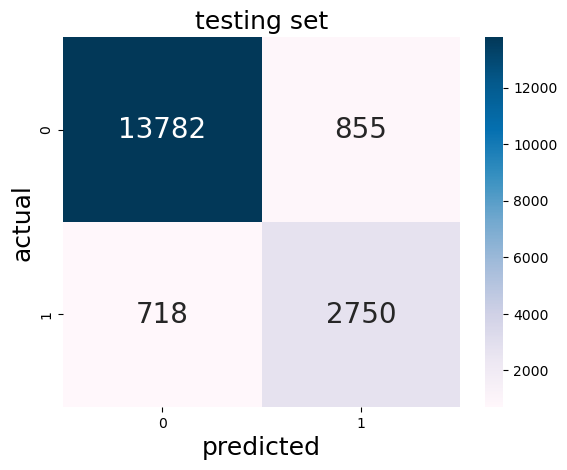

None


In [9]:
RunModel(RandomForestClassifier(random_state=0, class_weight='balanced', max_depth=30))

Recall:  0.7024221453287197
Accuracy:  0.8848936757801712
Precision:  0.698394495412844
F1:  0.7004025301897643


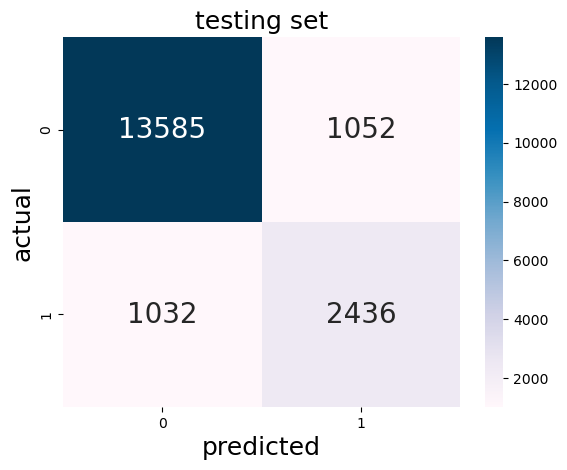

None


In [10]:
RunModel(DecisionTreeClassifier(random_state=0, class_weight='balanced'))

Recall:  0.697520184544406
Accuracy:  0.9008008837337752
Precision:  0.7640555906506633
F1:  0.7292734398552909


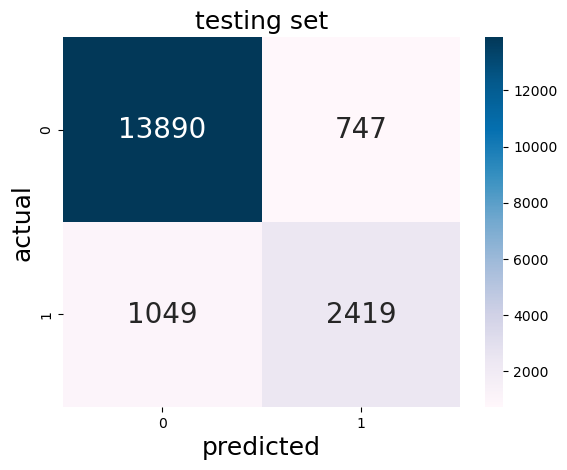

None


In [11]:
RunModel(KNeighborsClassifier())

Recall:  0.7494232987312572
Accuracy:  0.9132836233084783
Precision:  0.7875757575757576
F1:  0.7680260047281324


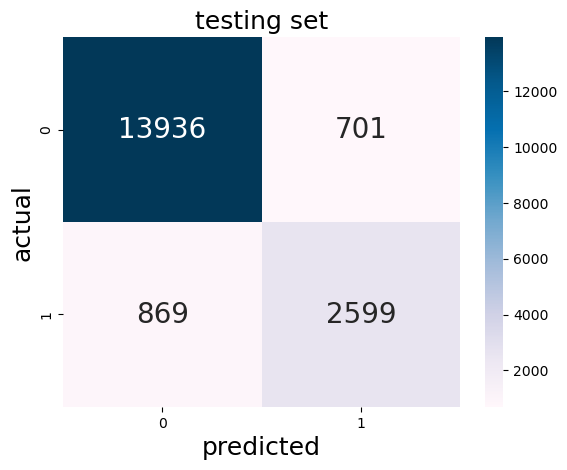

None


In [12]:
RunModel(XGBClassifier())

## Insights derived

We can hence say the following

1. XGBoostClassifier and RandomForest performed well. However DecisionTree perform several points worse than the other two models.
2. One of the major features were vote share and margin. This can be seen by looking at the feature importances below (the first few features were the numerical features).
3. Encoding the year with `LabelEncoder` instead of `OneHotEncoder` gives better results, since it utilises the order of years.

In [13]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf.fit(X_train, y_train)
rf.feature_importances_

array([6.78057822e-02, 2.47161908e-01, 2.13833950e-01, 2.10992232e-01,
       2.98925622e-02, 6.96990704e-02, 2.88021896e-04, 4.32049030e-03,
       3.41740498e-04, 2.00056960e-03, 4.48299043e-03, 3.60376646e-04,
       3.85109398e-04, 1.78260121e-05, 2.33185335e-04, 1.53143627e-04,
       1.25580600e-03, 3.53455804e-04, 5.53221370e-04, 2.00548219e-03,
       1.70531319e-03, 9.06733399e-04, 1.33767290e-03, 7.53077640e-04,
       1.82056041e-03, 2.12684321e-03, 1.68620595e-04, 3.19849566e-03,
       7.01426192e-04, 4.01294198e-03, 1.02942968e-03, 4.46161205e-04,
       2.62660347e-04, 6.76021717e-04, 2.37984602e-04, 2.36955302e-03,
       3.51929844e-04, 2.32007563e-03, 2.34290494e-03, 5.80611242e-04,
       6.95387350e-03, 3.28961450e-04, 5.06093032e-04, 6.29925565e-03,
       2.65303743e-04, 4.45599864e-03, 2.44398430e-03, 2.76763840e-03,
       8.02531885e-08, 1.18547309e-03, 5.12450741e-03, 4.00513920e-03,
       2.67034948e-03, 2.39125426e-03, 1.50184152e-03, 6.11171142e-04,
      